In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import tqdm.notebook as tqdm
from collections import Counter
import lemmy

import requests
from bs4 import BeautifulSoup
import re
import json

from nltk.corpus import stopwords
import stanfordnlp
%matplotlib inline

### Group 2

In [84]:
def houses_boliga(number_houses):
    """
    Returns a list of all ids for houses on boliga
    
    """
    house_id = list()
    url = "https://www.boliga.dk/resultat"
    
    for i in range(int(number_houses/50)):
        new_url = url + f"?page={i}"
        response = requests.get(new_url)
        html = response.text
        soup = BeautifulSoup(html,"html.parser")
        ids = soup.find_all("a",{"class":"house-list-item"})
        link_houses = list()

        for link in ids:
            link_houses.append(re.findall("(/\d{4,}/)",link["href"])[0].replace("/",""))
        
        house_id.extend(link_houses)
        
    return house_id

def get_info(id_list):
    
    """
    Take an list with ids of houses on boliga and gets specific data about these ids
    
    """
    all_df = list()
    new_keys = ["registeredArea","downPayment","estateUrl","currentArchiveId","forSaleNowId",
                "foreclosureId","selfsaleEstateId","cleanStreet","estateId","latitude","longitude",
               "propertyType","priceChangePercentTotal","energyClass","price","rooms","size","lotSize",
               "floor","buildYear","city","isActive","municipality","zipCode","street",
                "squaremeterPrice","daysForSale","createdDate","basementSize","views"]
    
    for house_id in id_list:
        response = requests.get(f'https://api.boliga.dk/api/v2/estate/{house_id}')
        response = response.json()
        df_dict = {key: response[key] for key in new_keys}
        df = pd.DataFrame(df_dict,index=[0])
        all_df.append(df)

    df = pd.concat(all_df,axis=0,ignore_index=True)
    
    return df

def get_reviews(df):
    bodys = list()
    #Finder alle ejendomsmæglere, som har mere end 100 huse til salg
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))
    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
    #Kører igennem alle links og finder tilhørende beskrivelse
    for link in tqdm.tqdm(df["estateUrl"].values):
        try:
            response = requests.get(link)
            html = response.text
            soup = BeautifulSoup(html,"html.parser")
            
            if link[8:15] =="home.dk": #Home
                ids = soup.find_all("div",{"class":"text"},"p")
                bodys.extend([x.p.text.replace("\n","").strip().lower() for x in ids[0:1] if len(x)>1])
            elif link[8:15] =="ww.skbo": #skbolig
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([sk.text.replace("\n","").replace("\r","").strip().lower() for sk in ids[0:1] if len(sk)>1])
            elif link[8:15] == "www.nyb": #Nybolig
                ids = soup.find_all("div",{"class":"foldable-spot__container"})
                bodys.extend([ny.text.replace("\n","").strip().lower() for ny in ids[0:1] if len(ny)>1])
            elif link [8:15] == "ww.elto": #Eltoft Nielsen
                ids = soup.find_all("br")
                bodys.extend([elto.text.replace("\n","").strip().lower() for elto in ids[0:1] if len(elto)>1])
            elif link[8:15] == "www.cla": #Claus Borg
                ids = soup.find_all("div",{"id":"case_content"})
                bodys.extend([cla.text.replace("\n","").strip().lower() for cla in ids[0:1] if len(cla)>1])
            elif link[8:15] == "www.lok": #Lokalbolig
                ids = soup.find_all("p")
                loka = [lok.text.replace("\n","").strip().lower() for lok in ids if len(lok.text)>100]
                bodys.extend([''.join(loka)])
            elif link[8:15] == "www.edc": #EDC Bolig
                ids = soup.find_all("div",{"class":"description"})
                bodys.extend([edc.text.replace("\n","").strip().lower() for edc in ids[0:1] if len(edc)>1])
            elif link[8:15] == "adamsch": #Adam Schnack
                ids = soup.find_all("div",{"class":"listing-text"})
                bodys.extend([adam.text.replace("\n","").strip().lower() for adam in ids[0:1] if len(adam)>1])
            elif link[8:20] == "www.estate.d": #Estate
                ids = soup.find_all("div",{"class":"property-description"})
                bodys.extend([est.text.replace("\n","").strip().lower() for est in ids[0:1] if len(est)>1])
            elif link[8:15] == "www.bri": #Brikk Ejendomme
                ids = soup.find_all("div",{"class":"prop-user-content"})
                bodys.extend([bri.text.replace("\n","").strip().lower() for bri in ids[0:1] if len(bri)>1])
            elif link[8:15] == "www.rea": #Realmæglerne
                ids = soup.find_all("div",{"class":"text-full"})
                bodys.extend([rea.text.replace("\n","").strip().lower() for rea in ids[0:1] if len(rea)>1])
            elif link[8:15] == "danboli": #Danbolig
                ids = soup.find_all("div",{"class":"db-description-block"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>1])
            elif link[8:15] == "ww.lili": #Lillenhof
                ids = soup.find_all("div",{"class":"inner"})
                bodys.extend([dan.text.replace("\n","").strip().lower() for dan in ids[0:1] if len(dan)>10])
            elif link[8:15] == "bjornby":
                ids = soup.find_all("div",{"class":"content d-md-block d-none wrap-content"})
                bodys.extend([bjor.text.replace("\n","").strip() for bjor in ids[0:1] if len(bjor)>10])
            elif link[8:15] == 'www.hov': #Hovmand
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([hov.text.replace("\n","").strip() for hov in ids[0:1] if len(hov)>1])
            elif link[8:15] == 'ww.jesp': #Jesper Nielsen
                ids = soup.find_all("div",{"class":"case-description"})
                bodys.extend([jesp.text.replace("\n","").strip() for jesp in ids[0:1] if len(jesp)>1])
            elif link[8:15] == "www.sel": #Selvsalg
                ids = soup.find_all("div",{"class":"tab-pane active fade in"})
                bodys.extend([selv.text.replace("\n","").strip() for selv in ids[0:1] if len(selv)>1])
            elif link[8:15] == "www.bol": #Bolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == 'www.joh': #Johns
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([john.text.replace("\n","").strip() for john in ids[0:1] if len(john)>1])
            elif link[8:15] == "racking": #Robinhus
                ids = soup.find_all("div",{"class":"text-container"})
                bodys.extend([robin.text.replace("\n","").strip() for robin in ids[0:1] if len(robin)>1])
            elif link[8:15] == "www.min": #minbolighandel
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([minb.text.replace("\n","").strip() for minb in ids[0:1] if len(minb)>1])
            elif link[8:15] == "ww.unni": #Unnibolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "www.sdb": #Sdb bolig
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([un.text.replace("\n","").strip() for un in ids[0:1] if len(un)>1])
            elif link[8:15] == "ww.land":#Landobolig
                ids = soup.find_all("div",{"class":"col-md-8"})
                bodys.extend([land.text.replace("\n","").strip() for land in ids[0:1] if len(land)>1])
            elif link[8:15] == "www.ber": #Bermistof
                ids = soup.find_all("div",{"class":"column"})
                bodys.extend([ber.text.replace("\n","").strip() for ber in ids[0:1] if len(ber)>1])
            elif link [8:20] == 'www.carlsber': #Carlsberg Byen
                ids = soup.find_all("div",{"itemprop":"description"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == "www.car": #Carsten Nordbo
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([car.text.replace("\n","").strip() for car in ids[0:1] if len(car)>1])
            elif link[8:15] == 'ww.agri': 
                ids = soup.find_all("div",{"class":"col-md-8 col-sm-7 hidden-xs text-box desktop"})
                bodys.extend([agr.text.replace("\n","").strip() for agr in ids[0:1] if len(agr)>1])
            elif link[8:15] == "www.pla":#Place2Live
                ids = soup.find_all("div",{"class":"col-lg-16"})
                bodys.extend([pla.text.replace("\n","").strip() for pla in ids[0:1] if len(pla)>1])
            elif link[8:15] == "www.vil": #Villadsenbolig
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([vil.text.replace("\n","").strip() for vil in ids[0:1] if len(vil)>1])
            elif link[8:15] == 'maegler': #Mæglerhuset
                ids = soup.find_all("div",{"class":"case-text"})
                bodys.extend([mae.text.replace("\n","").strip() for mae in ids[0:1] if len(mae)>1])
            elif link[8:15] == 'ww.thom': #ThomasJørgensen
                ids = soup.find_all("div",{"class":"description col-md-16"})
                bodys.extend([thom.text.replace("\n","").strip() for thom in ids[0:1] if len(thom)>1])
            elif link[8:15] == 'www.htb': #HTbolig
                ids = soup.find_all("div",{"class":"left-side global-style"})
                bodys.extend([htb.text.replace("\n","").strip() for htb in ids[0:1] if len(htb)>1])
            elif link[8:15] == 'ww.boli': #Boligone
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([bol.text.replace("\n","").strip() for bol in ids[0:1] if len(bol)>1])
            elif link[8:15] == "www.mæg":#Mæglerringen
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([ma.text.replace("\n","").strip() for ma in ids[0:1] if len(ma)>1])
            elif link[8:15] == "ww.vest":
                ids = soup.find_all("div",{"class":"first-col"})
                bodys.extend([vest.text.replace("\n","").strip() for vest in ids[0:1] if len(vest)>1])
            elif link[8:15] == "www.tho": #Thorregård
                ids = soup.find_all("div",{"class":"annonce rammebaggrund"})
                bodys.extend([th.text.replace("\n","").strip() for th in ids[0:1] if len(th)>1])
            elif link[8:15] == "byggegr": #Byggegrund
                ids = soup.find_all("div",{"class":"section section-12"})
                bodys.extend([byg.text.replace("\n","").strip() for byg in ids[0:1] if len(byg)>1])
            elif link[8:15] == "grundsa": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] == "rundsal": #Grundsalg
                bodys.append(np.nan)
            elif link[8:15] =="ww.paul": #paulun
                bodys.append(np.nan)
            else:
                bodys.append(np.nan)
                if link[8:15] in over_100:
                    print("Missing", link[8:15])
        except:
            print(link,"virkede ikke")
            continue
    
    return bodys

def find_realtors(df):
    """
    This function finds all realtors, who has more that 100 houses for sale.
    Used to find the structure for all realtors of relevance
    """
    realtors_link = list()
    #Finder alle ejendomsmæglere, som har mere end 100 huse til salg
    estates = list()
    for value in df["estateUrl"].values:
        estates.append(value[8:15])
    numbers = dict(Counter(estates))

    over_100 = dict() 
    for key, value in numbers.items():
        if value > 100:
            over_100[key] = value
    already_accounted = list()
    for link in tqdm.tqdm(df["estateUrl"].values):        
        if link[8:15] in over_100.keys():
            if link[8:15] not in already_accounted:
                print(link,"not in loop")
                print(link[8:15])
                realtors_link.append(link[8:15])
                already_accounted.append(link[8:15])

    return realtors_link
    
def preprocess_csv(csv):
    """
    This function loads the dataset from boliga annd preproccesses it.
    """
    df = pd.read_csv(csv,index_col="Unnamed: 0")
    y = df["price"].values
    #Generating dummy variables - Property type
    housing_type={1:'villa',2:'raekkehuse', 3:'ejerlejlighed',4:'fritidshus', 5:'andel',6:'landejendom', 
              7:'helrsgrund',8:'fritidsgrund', 9:'villalejlighed',10:'andet_1',11:"andet_2",12:"andet_3"}
    dummy_df = pd.get_dummies(df['propertyType'])   
    df = df.join(dummy_df)
    df.drop("propertyType",axis=1,inplace=True)
    df.rename(columns = housing_type,inplace=True)
    
    #Dropping all None house
    df = df[(df["helrsgrund"] == 0) & (df["andet_2"] == 0) & (df["andet_3"] == 0)]
    
    #Generation dummies variables - Kommune
    dummy_mun = pd.get_dummies(df["kommune_navn"])
    df = df.join(dummy_mun)
    df.drop("kommune_navn",inplace=True,axis=1)
    
    #Generation dummies variables - Floor
    dummy_floor = pd.get_dummies(df["floor"].map(str))
    df = df.join(dummy_floor)
    df.drop("floor",inplace=True,axis=1)
    
    #Removing houses not placed in Denmark
    df = df[(df["latitude"]<60) & (df["latitude"]>53) & (df["longitude"]>7) & (df["longitude"]<16)]
    
    #Making room per sqm
    df["rooms_per_sqm"] = df["rooms"]/df["size"]
    
    #Dropping all non essential columns
    df.drop(["Unnamed: 0.1","downPayment","estateUrl","currentArchiveId","forSaleNowId",
            "foreclosureId","cleanStreet","estateId","latitude","longitude","energyClass",
            "price","city","isActive","municipality","zipCode","street","createdDate",
            "squaremeterPrice","region","kommune_nr","rooms"],axis=1,inplace=True)
    
    X = df.values
    
    return X, y, df

def preprocess_text(string):
    #Removing punctuation
    string = re.sub(r'[^\w\s]','',string)
    
    #Lemmatizing words
    lemmatizer = lemmy.load("da")
    string = lemmatizer.lemmatize("",string)[0].split()

    #Removing stopwords
    stop_words_list = stopwords.words("danish")
    string = [i for i in nltk.word_tokenize(string.lower()) if i not in stop_words_list]
    
    nlp = stanfordnlp.Pipeline(lang="da")
    doc = nlp(string)
    
    [(word.text, word.upos) for sentence in doc.sentences for word in sentence.words]
    
    return string

def words_count(list_of_strings):
    sentences = list_of_strings
    counts = dict(Counter(sentences))
    
    return counts

def add_lonlat(df,df_station):
    min_dist = list()
    for location in tqdm(df["location"]):
        distance = list()
        for lon,lat in zip(df_station["lon"],df_station["lat"]):
            distance.append(geodesic((lat,lon), location).km)
    
        min_dist.append(min(distance))
        
    df["dist_station"] = min_dist
    
    return df

In [25]:
X, y, df = preprocess_csv("house_data_final.csv")
len(np.unique(np.array(df["currentArchiveId"].values)))

47454

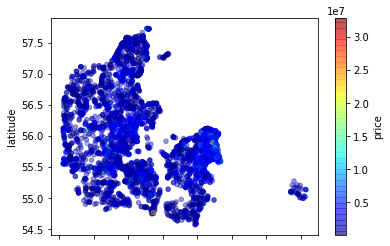

In [13]:
df.sample(frac=0.1).plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
       c="price",cmap=plt.get_cmap("jet"),colorbar=True)

In [21]:
sum(df["price"]<1500000)

20177

In [85]:
X, y, df = preprocess_csv("house_data_final.csv")

In [86]:
print(df.columns.values)

['registeredArea' 'selfsaleEstateId' 'priceChangePercentTotal' 'size'
 'lotSize' 'buildYear' 'daysForSale' 'basementSize' 'views' 'dist_station'
 'villa' 'raekkehuse' 'ejerlejlighed' 'fritidshus' 'andel' 'landejendom'
 'helrsgrund' 'fritidsgrund' 'villalejlighed' 'andet_2' 'andet_3'
 'Aabenraa Kommune' 'Albertslund Kommune' 'Allerød Kommune'
 'Assens Kommune' 'Ballerup Kommune' 'Billund Kommune' 'Bornholm Kommune'
 'Brøndby Kommune' 'Christiansø' 'Dragør Kommune' 'Egedal Kommune'
 'Esbjerg Kommune' 'Faaborg-Midtfyn Kommune' 'Fanø Kommune' 'Faxe Kommune'
 'Fredensborg Kommune' 'Fredericia Kommune' 'Frederiksberg Kommune'
 'Frederikssund Kommune' 'Furesø Kommune' 'Gentofte Kommune'
 'Gladsaxe Kommune' 'Glostrup Kommune' 'Greve Kommune' 'Gribskov Kommune'
 'Guldborgsund Kommune' 'Haderslev Kommune' 'Halsnæs Kommune'
 'Hedensted Kommune' 'Helsingør Kommune' 'Herlev Kommune'
 'Herning Kommune' 'Hillerød Kommune' 'Holbæk Kommune' 'Holstebro Kommune'
 'Hvidovre Kommune' 'Høje-Taastrup Kommune

In [77]:
df[df[46.0]==1]

,registeredArea,selfsaleEstateId,priceChangePercentTotal,rooms,size,lotSize,buildYear,daysForSale,basementSize,views,...,14.0,15.0,16.0,17.0,18.0,19.0,21.0,28.0,29.0,46.0
16959,290,0,-14,8.0,290,1418,1775,246,0,2,...,0,0,0,0,0,0,0,0,0,1


In [83]:
X

array([[ 68.,   0.,   0., ...,   0.,   0.,   1.],
       [ 78.,   0.,   0., ...,   0.,   0.,   0.],
       [117.,   0.,   0., ...,   0.,   0.,   1.],
       ...,
       [158.,   0.,   0., ...,   0.,   0.,   1.],
       [158.,   0.,   0., ...,   0.,   0.,   1.],
       [358.,   0.,  -9., ...,   0.,   0.,   1.]])

In [88]:
from nltk.corpus import stopwords
words = stopwords.words("danish")
len(words)

94

In [89]:
words

['og',
 'i',
 'jeg',
 'det',
 'at',
 'en',
 'den',
 'til',
 'er',
 'som',
 'på',
 'de',
 'med',
 'han',
 'af',
 'for',
 'ikke',
 'der',
 'var',
 'mig',
 'sig',
 'men',
 'et',
 'har',
 'om',
 'vi',
 'min',
 'havde',
 'ham',
 'hun',
 'nu',
 'over',
 'da',
 'fra',
 'du',
 'ud',
 'sin',
 'dem',
 'os',
 'op',
 'man',
 'hans',
 'hvor',
 'eller',
 'hvad',
 'skal',
 'selv',
 'her',
 'alle',
 'vil',
 'blev',
 'kunne',
 'ind',
 'når',
 'være',
 'dog',
 'noget',
 'ville',
 'jo',
 'deres',
 'efter',
 'ned',
 'skulle',
 'denne',
 'end',
 'dette',
 'mit',
 'også',
 'under',
 'have',
 'dig',
 'anden',
 'hende',
 'mine',
 'alt',
 'meget',
 'sit',
 'sine',
 'vor',
 'mod',
 'disse',
 'hvis',
 'din',
 'nogle',
 'hos',
 'blive',
 'mange',
 'ad',
 'bliver',
 'hendes',
 'været',
 'thi',
 'jer',
 'sådan']